In [1]:
# Importing libraries
import pickle
import itertools
import string
import re
import numpy as np
import pandas as pd
import multiprocessing
from collections import Counter
from scipy.sparse import csr_matrix
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sn
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### Load the preprocessed data from the data_directory

In [2]:
data_directory = "Generated_Files/data_after_preprocessing.csv"

### We devide the data into 3 groups:
* Group 1: full data
* Group 2: data with four large categories which have more than 1000 companies each
* Group 3: seven categories of data, number of companies in each category is same but small

### In the function selectGroup, giving 1, 2 or 3 as input parameter to selet the relevant data for experiment

In [3]:
# read the data from directory, then select the group 
# of data we want to process.
def selectGroup(directory, group_nr):
    data = pd.read_csv(directory, sep='\t')
    if group_nr == 1:
        return data
    if group_nr == 2:
        df_healthcare_group=data[data['Category'] == 'HEALTHCARE GROUP'].sample(n=1041,replace=False)
        df_business_financial_services=data[data['Category'] == 'BUSINESS & FINANCIAL SERVICES'].sample(n=1041,replace=False)
        df_consumer_service_group=data[data['Category'] == 'CONSUMER SERVICES GROUP'].sample(n=1041,replace=False)
        df_information_technology_group=data[data['Category'] == 'INFORMATION TECHNOLOGY GROUP'].sample(n=1041,replace=False)
        df_clean = pd.concat([df_healthcare_group, df_business_financial_services,df_consumer_service_group,df_information_technology_group])
        return df_clean.sample(frac=1)
    if group_nr == 3:
        df_healthcare_group=data[data['Category'] == 'HEALTHCARE GROUP'].sample(n=219,replace=False)
        df_business_financial_services=data[data['Category'] == 'BUSINESS & FINANCIAL SERVICES'].sample(n=219,replace=False)
        df_consumer_service_group=data[data['Category'] == 'CONSUMER SERVICES GROUP'].sample(n=219,replace=False)
        df_information_technology_group=data[data['Category'] == 'INFORMATION TECHNOLOGY GROUP'].sample(n=219,replace=False)
        df_industry_goods=data[data['Category'] == 'INDUSTRIAL GOODS & MATERIALS GROUP'].sample(n=219,replace=False)
        df_consumer_goods=data[data['Category'] == 'CONSUMER GOODS GROUP'].sample(n=219,replace=False)
        df_energy=data[data['Category'] == 'ENERGY & UTILITIES GROUP'].sample(n=219,replace=False)
        df_clean = pd.concat([df_healthcare_group, df_business_financial_services,df_consumer_service_group,df_information_technology_group,df_industry_goods,df_consumer_goods,df_energy])
        return df_clean.sample(frac=1)

In [4]:
# Select and Split the data
data = selectGroup(data_directory, 1)
train, test = train_test_split(data, test_size=0.2, random_state=42)

### Train and Build the doc2vec model

In [5]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['clean']), tags=[r.Category]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['clean']), tags=[r.Category]), axis=1)
cores = multiprocessing.cpu_count()

# Distributed Bag of Words (DBOW)
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 5405/5405 [00:00<00:00, 1755067.98it/s]


In [6]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 5405/5405 [00:00<00:00, 1659727.15it/s]


CPU times: user 1h 7min 48s, sys: 46.6 s, total: 1h 8min 35s
Wall time: 12min 25s


In [7]:
# Distributed Memory (DM)   
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 5405/5405 [00:00<00:00, 1508431.24it/s]


In [8]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 5405/5405 [00:00<00:00, 1712769.20it/s]


CPU times: user 1h 58min 53s, sys: 44.7 s, total: 1h 59min 38s
Wall time: 26min 47s


In [10]:
# Pair Distributed Bag of Words (DBOW) and Distributed Memory (DM)  
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [12]:
# Infer vectors from the doc2vec model
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors
y_train, X_train = get_vectors(new_model, train_tagged)
print("Infer vector done for train data")
y_test, X_test = get_vectors(new_model, test_tagged)

Infer vector done for train data


### Use PCA and T-SNE to visualize the data distribution of different classes when using doc2vec to present them

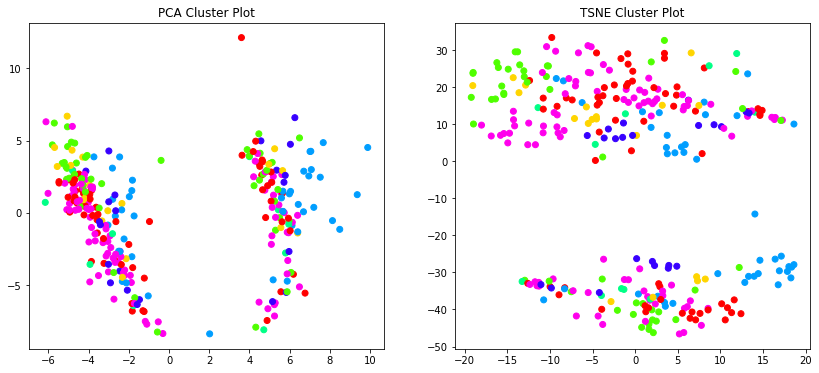

In [13]:
#Original Category Visualization
X = X_train + X_test
y = y_train + y_test
X = csr_matrix(pd.DataFrame(list(X)))
categories = ['BUSINESS & FINANCIAL SERVICES', 'CONSUMER GOODS GROUP', 'CONSUMER SERVICES GROUP', 'ENERGY & UTILITIES GROUP', 'HEALTHCARE GROUP', 'INDUSTRIAL GOODS & MATERIALS GROUP', 'INFORMATION TECHNOLOGY GROUP'] 
new_label = [0, 1, 2, 3, 4, 5, 6]
mydict=dict(zip(categories, new_label))
y_tsne = np.zeros(len(y))
for index, label in enumerate(y):
    y_tsne[index] = mydict[label] 
    
def plot_tsne_pca(data, labels):
    max_label = max(labels+1)
    max_items = np.random.choice(range(data.shape[0]), size=1000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(X, y_tsne)

### Use Unsupervised Learning method to classify the companies and visualize the clusters by PCA and T-SNE based on the vectors generated from Doc2Vec - Kmeans

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters


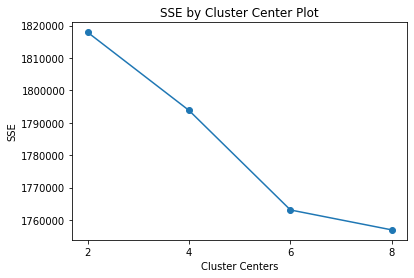

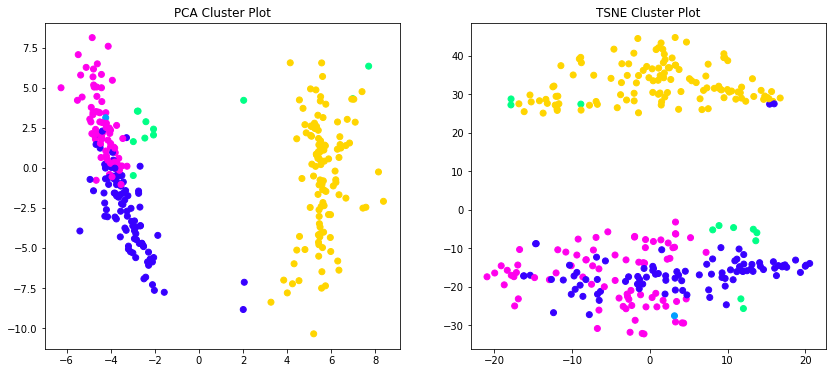

In [14]:
#K-Means Assigned Category Visualization
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=128, batch_size=256, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
def plot_tsne_pca(data, labels):
    max_label = max(labels+1)
    max_items = np.random.choice(range(data.shape[0]), size=1000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
find_optimal_clusters(X, 8)  
clusters = MiniBatchKMeans(n_clusters=7, init_size=256, batch_size=256, random_state=20).fit_predict(X)    
plot_tsne_pca(X, clusters)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       416
         1.0       0.27      0.37      0.32      1885
         2.0       0.00      0.00      0.00       219
         3.0       0.13      0.04      0.06      1041
         4.0       0.00      0.00      0.00       477
         5.0       0.23      0.30      0.26      1579
         6.0       0.17      0.26      0.20      1140

    accuracy                           0.23      6757
   macro avg       0.12      0.14      0.12      6757
weighted avg       0.18      0.23      0.19      6757



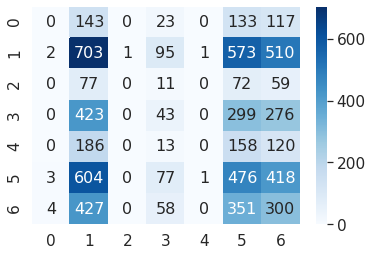

[[  0 143   0  23   0 133 117]
 [  2 703   1  95   1 573 510]
 [  0  77   0  11   0  72  59]
 [  0 423   0  43   0 299 276]
 [  0 186   0  13   0 158 120]
 [  3 604   0  77   1 476 418]
 [  4 427   0  58   0 351 300]]


In [15]:
# Map category names to K-mean clusters based on data accuracy
def Calculate_accuracy(clusters, actual_label):
    count = 0 
    for index, cluster in enumerate(clusters):
        if cluster==actual_label[index]:
            count+=1
    accuracy = count/len(clusters)*1.0
    return accuracy

def assign_clusters(original_label, permu):
    categories = ['BUSINESS & FINANCIAL SERVICES', 'CONSUMER GOODS GROUP', 'CONSUMER SERVICES GROUP', 'ENERGY & UTILITIES GROUP', 'HEALTHCARE GROUP', 'INDUSTRIAL GOODS & MATERIALS GROUP', 'INFORMATION TECHNOLOGY GROUP'] 
    mydict=dict(zip(categories, permu))
    actual_label = np.zeros(len(original_label))
    for index, label in enumerate(original_label):
        actual_label[index] = mydict[label] 
    return actual_label
numbers=np.zeros(7)
for i in range(7):
        numbers[i] = i 
permu = list(itertools.permutations(numbers))
best_accuracy = 0
for i in range(len(permu)):
    actual_label = assign_clusters(data['Category'].values, permu[i])
    accuracy = Calculate_accuracy(clusters, actual_label)
    if best_accuracy<accuracy:
        best_accuracy=accuracy
        final_label = actual_label
        category = permu[i]
    else: best_accuracy=best_accuracy

print(classification_report(final_label,clusters))

df_cm = pd.DataFrame(confusion_matrix(final_label,clusters), range(7),
                  range(7))
sn.set(font_scale=1.4)#for label size
ax = sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()
    
print(confusion_matrix(final_label,clusters))  

### Use different Supervised Learning methods to classify the companies based on the vectors generated from Doc2Vec - Linear SVM, Logistic Regression, KNN

start svm
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[[142   5  51  10  17  26  87]
 [  6  28  18   2   6  10   5]
 [ 31  14 121   3  20   3  50]
 [  8   0   2  16   1  10   5]
 [ 11   8   8   0 157   8  17]
 [  3   7   8   3   7  39  13]
 [ 84   7  40   4  21  13 197]]


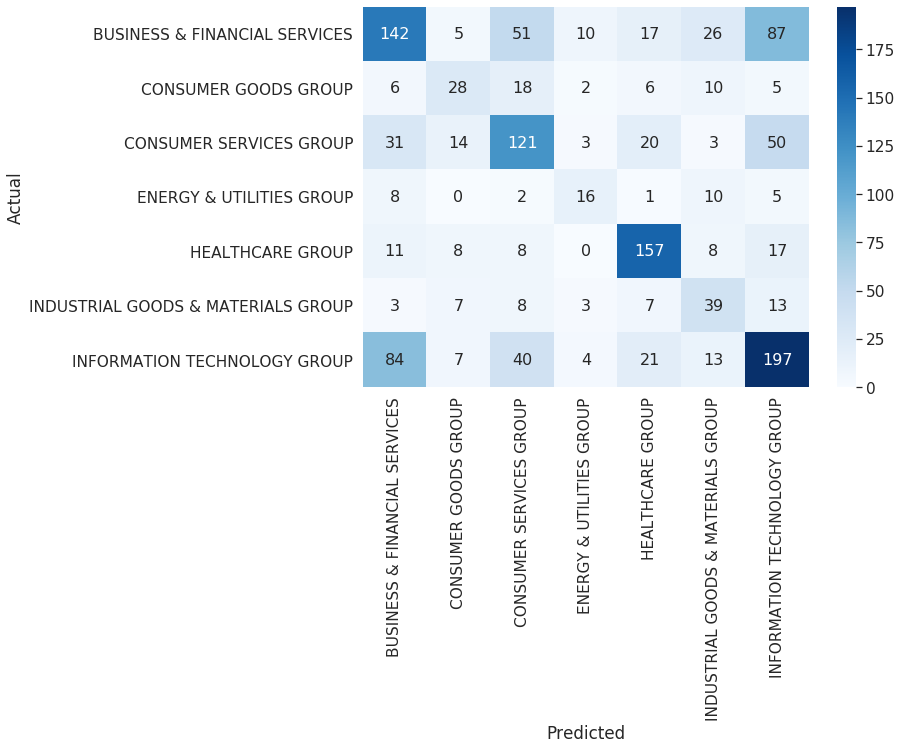

                                    precision    recall  f1-score   support

     BUSINESS & FINANCIAL SERVICES       0.50      0.42      0.46       338
              CONSUMER GOODS GROUP       0.41      0.37      0.39        75
           CONSUMER SERVICES GROUP       0.49      0.50      0.49       242
          ENERGY & UTILITIES GROUP       0.42      0.38      0.40        42
                  HEALTHCARE GROUP       0.69      0.75      0.72       209
INDUSTRIAL GOODS & MATERIALS GROUP       0.36      0.49      0.41        80
      INFORMATION TECHNOLOGY GROUP       0.53      0.54      0.53       366

                          accuracy                           0.52      1352
                         macro avg       0.48      0.49      0.49      1352
                      weighted avg       0.52      0.52      0.52      1352

0.5177514792899408


In [16]:
#Linear SVM Classifier
def linear_svc_classifier(train_x, train_y, test_x, test_y):
    print("start svm")
    classifier_svm = svm.LinearSVC(verbose=1)
    # classifier_svm = svm.SVC(kernel='linear')
    classifier_svm.fit(train_x, train_y)
    predictions = classifier_svm.predict(test_x)
    
    confusion = confusion_matrix(test_y, predictions)
    print(confusion)
    y_true = ["BUSINESS & FINANCIAL SERVICES", "CONSUMER GOODS GROUP", "CONSUMER SERVICES GROUP", "ENERGY & UTILITIES GROUP", "HEALTHCARE GROUP", "INDUSTRIAL GOODS & MATERIALS GROUP", "INFORMATION TECHNOLOGY GROUP"]
    y_pred = ["BUSINESS & FINANCIAL SERVICES", "CONSUMER GOODS GROUP", "CONSUMER SERVICES GROUP", "ENERGY & UTILITIES GROUP", "HEALTHCARE GROUP", "INDUSTRIAL GOODS & MATERIALS GROUP", "INFORMATION TECHNOLOGY GROUP"]
    df_cm = pd.DataFrame(confusion, y_true, y_pred)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7)) 
    ax = sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()
    print(classification_report(test_y, predictions))
    print(accuracy_score(test_y, predictions))
    
linear_svc_classifier(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[[143   3  53  11  19  19  90]
 [  4  33  18   2   4   8   6]
 [ 27  19 123   0  13   2  58]
 [  7   0   0  19   0  10   6]
 [  6   6   9   0 165   7  16]
 [  7   5   7   1   5  44  11]
 [ 80   5  42   3  20  12 204]]


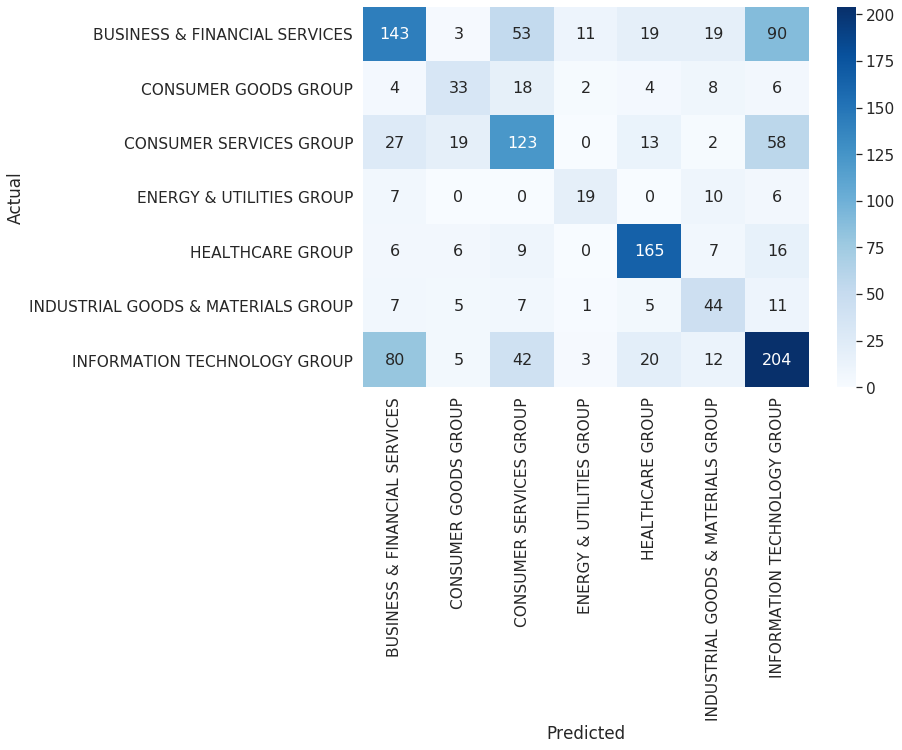

                                    precision    recall  f1-score   support

     BUSINESS & FINANCIAL SERVICES       0.52      0.42      0.47       338
              CONSUMER GOODS GROUP       0.46      0.44      0.45        75
           CONSUMER SERVICES GROUP       0.49      0.51      0.50       242
          ENERGY & UTILITIES GROUP       0.53      0.45      0.49        42
                  HEALTHCARE GROUP       0.73      0.79      0.76       209
INDUSTRIAL GOODS & MATERIALS GROUP       0.43      0.55      0.48        80
      INFORMATION TECHNOLOGY GROUP       0.52      0.56      0.54       366

                          accuracy                           0.54      1352
                         macro avg       0.53      0.53      0.53      1352
                      weighted avg       0.54      0.54      0.54      1352

0.540680473372781


In [17]:
# Logistic Classifier
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logistic_pred = logreg.predict(X_test)

confusion = confusion_matrix(y_test, logistic_pred)
print(confusion)
y_true = ["BUSINESS & FINANCIAL SERVICES", "CONSUMER GOODS GROUP", "CONSUMER SERVICES GROUP", "ENERGY & UTILITIES GROUP", "HEALTHCARE GROUP", "INDUSTRIAL GOODS & MATERIALS GROUP", "INFORMATION TECHNOLOGY GROUP"]
y_pred = ["BUSINESS & FINANCIAL SERVICES", "CONSUMER GOODS GROUP", "CONSUMER SERVICES GROUP", "ENERGY & UTILITIES GROUP", "HEALTHCARE GROUP", "INDUSTRIAL GOODS & MATERIALS GROUP", "INFORMATION TECHNOLOGY GROUP"]
df_cm = pd.DataFrame(confusion, y_true, y_pred)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7)) 
ax = sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()
print(classification_report(y_test, logistic_pred))
print(accuracy_score(y_test, logistic_pred))

                                    precision    recall  f1-score   support

     BUSINESS & FINANCIAL SERVICES       0.40      0.43      0.41       310
              CONSUMER GOODS GROUP       0.36      0.32      0.34        85
           CONSUMER SERVICES GROUP       0.42      0.50      0.46       204
          ENERGY & UTILITIES GROUP       0.36      0.56      0.43        27
                  HEALTHCARE GROUP       0.66      0.62      0.64       221
INDUSTRIAL GOODS & MATERIALS GROUP       0.50      0.41      0.45        98
      INFORMATION TECHNOLOGY GROUP       0.52      0.47      0.49       407

                          accuracy                           0.48      1352
                         macro avg       0.46      0.47      0.46      1352
                      weighted avg       0.48      0.48      0.48      1352



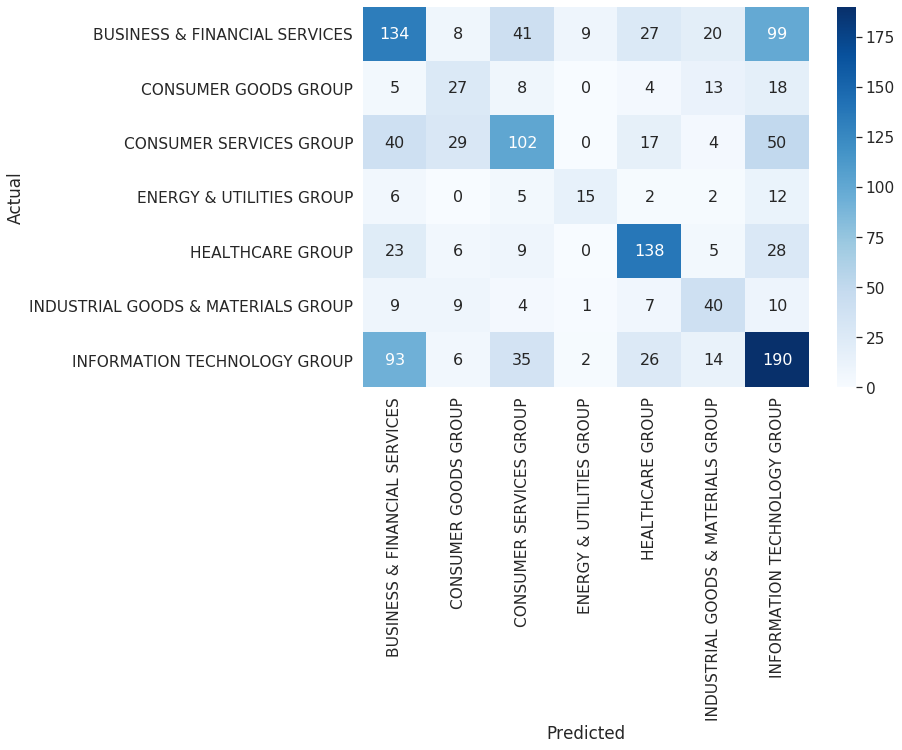

[[134   5  40   6  23   9  93]
 [  8  27  29   0   6   9   6]
 [ 41   8 102   5   9   4  35]
 [  9   0   0  15   0   1   2]
 [ 27   4  17   2 138   7  26]
 [ 20  13   4   2   5  40  14]
 [ 99  18  50  12  28  10 190]]


In [18]:
# KNN classifier
def grid_search(Max, X_data, y_data):
    KNN_Best_Accuracy = 0
    for n in range(5,Max):
        modelknn = KNeighborsClassifier(n_neighbors=n)
        modelknn.fit(X_data,y_data)
        Accuracy = Calculate_accuracy(modelknn.predict(X_data), y_data)
        if KNN_Best_Accuracy< Accuracy: 
            KNN_Best_Accuracy = Accuracy
            Bestknnmodel = KNeighborsClassifier(n_neighbors=n)
            Bestknnmodel.fit(X_data,y_data)
        else: KNN_Best_Accuracy = KNN_Best_Accuracy
    #print(n)
    #print(KNN_Best_Accuracy)
    return Bestknnmodel

Bestknnmodel = grid_search(6, X_train, y_train)
predicted_labels_knn = Bestknnmodel.predict(X_test)

print(classification_report(predicted_labels_knn,y_test))
y_true = ["BUSINESS & FINANCIAL SERVICES", "CONSUMER GOODS GROUP", "CONSUMER SERVICES GROUP", "ENERGY & UTILITIES GROUP", "HEALTHCARE GROUP", "INDUSTRIAL GOODS & MATERIALS GROUP", "INFORMATION TECHNOLOGY GROUP"]
y_pred = ["BUSINESS & FINANCIAL SERVICES", "CONSUMER GOODS GROUP", "CONSUMER SERVICES GROUP", "ENERGY & UTILITIES GROUP", "HEALTHCARE GROUP", "INDUSTRIAL GOODS & MATERIALS GROUP", "INFORMATION TECHNOLOGY GROUP"]
df_cm = pd.DataFrame(confusion_matrix(y_test, predicted_labels_knn), y_true, y_pred)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))

ax = sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()
    
print(confusion_matrix(predicted_labels_knn,y_test))

### Save the doc2vec model for future usage

In [19]:
# save the model to disk
filename = 'Generated_Files/doc2vec_model.sav'
pickle.dump(new_model, open(filename, 'wb'))